In [64]:
%run header.py data/ASIC-2-FPGA

Python version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.20.1
matplotlib version: 2.0.2
NumPy version: 1.14.1
SciPy version: 1.0.0
IPython version: 5.3.0
scikit-learn version: 0.19.1
-------------------------


In [3]:
# Load exhaustive training results
es_v4_lr = pd.read_csv('es_v4_lr.csv')
es_v4_ada = pd.read_csv('es_v4_ada.csv')
es_v4_rf = pd.read_csv('es_v4_rf.csv')

# direct mapping
dm_v4 = pd.read_csv('direct_mapping_v4.csv')
dm_v5 = pd.read_csv('direct_mapping_v5.csv')

# direct mapping with tolerance
dm_v4_01 = pd.read_csv('direct_mapping_v4_tolerance_0.1.csv')
dm_v5_01 = pd.read_csv('direct_mapping_v5_tolerance_0.1.csv')
dm_v4_005 = pd.read_csv('direct_mapping_v4_tolerance_0.05.csv')
dm_v5_005 = pd.read_csv('direct_mapping_v5_tolerance_0.05.csv')

In [12]:
benchmark = 'interpolation'

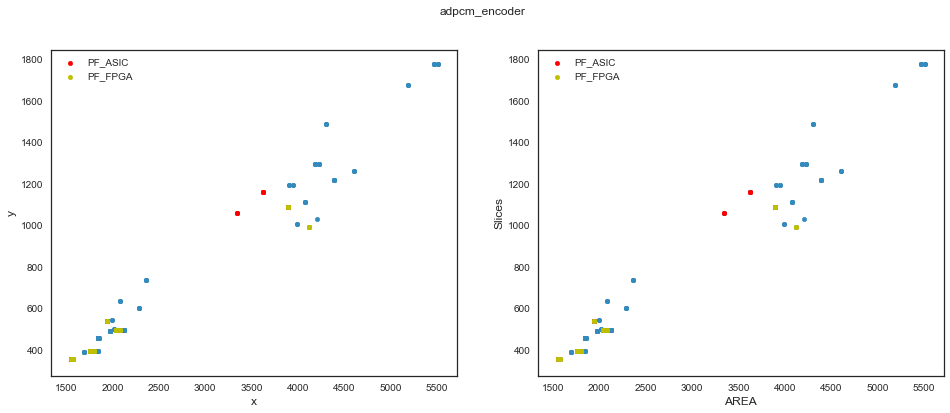

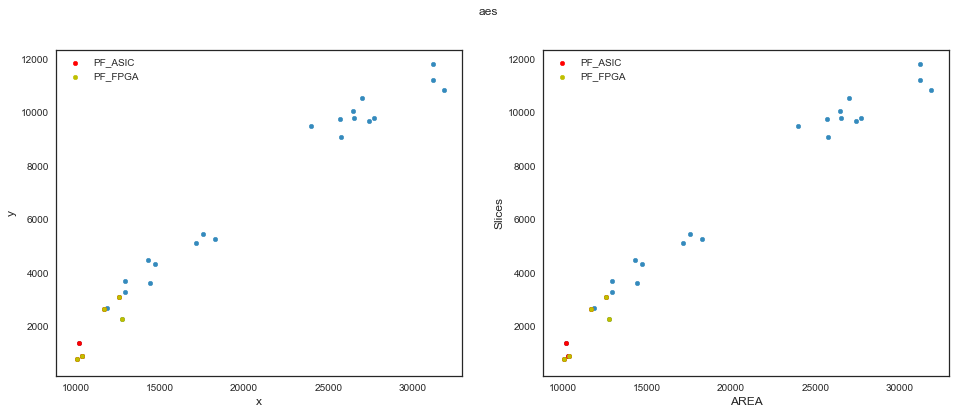

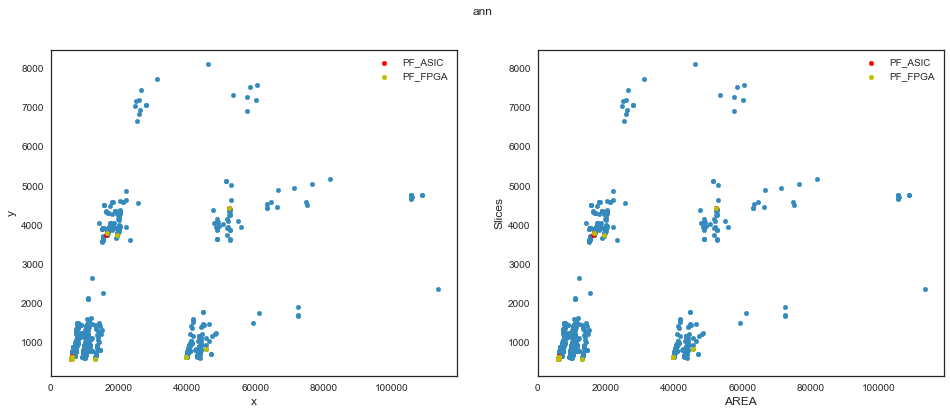

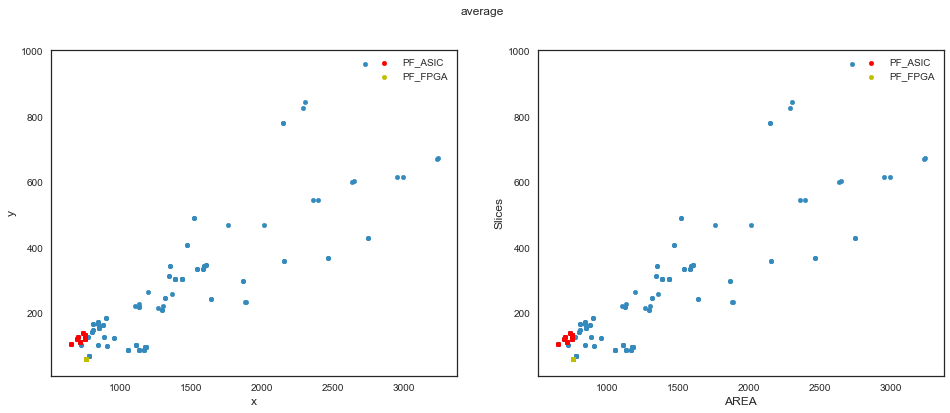

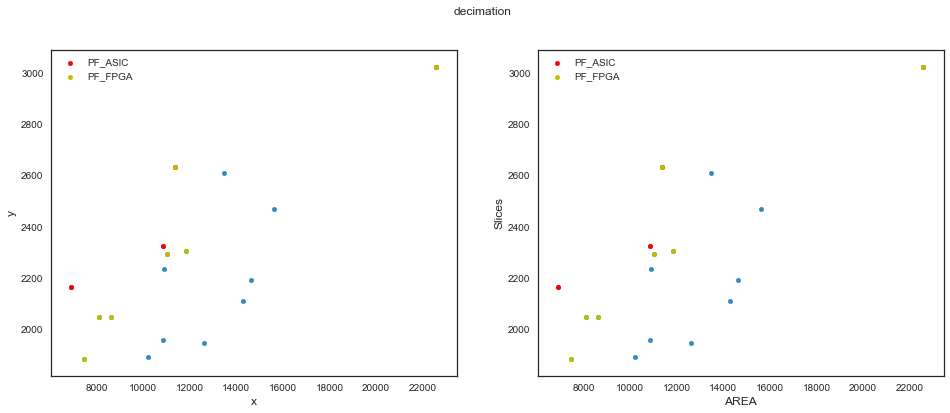

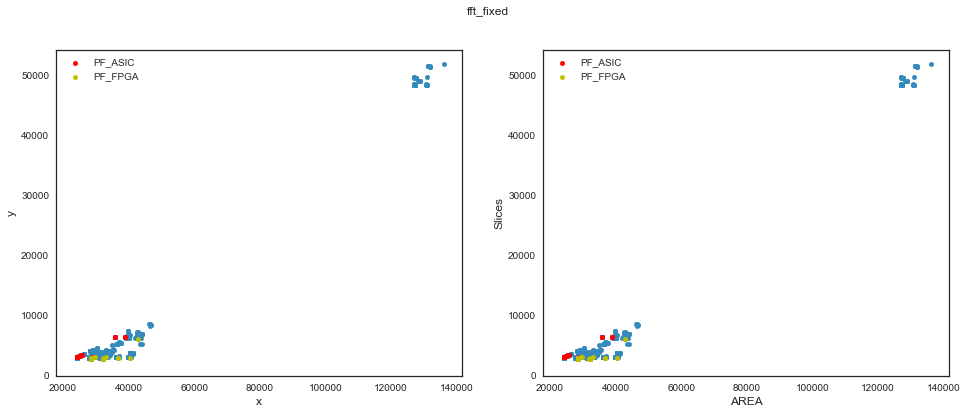

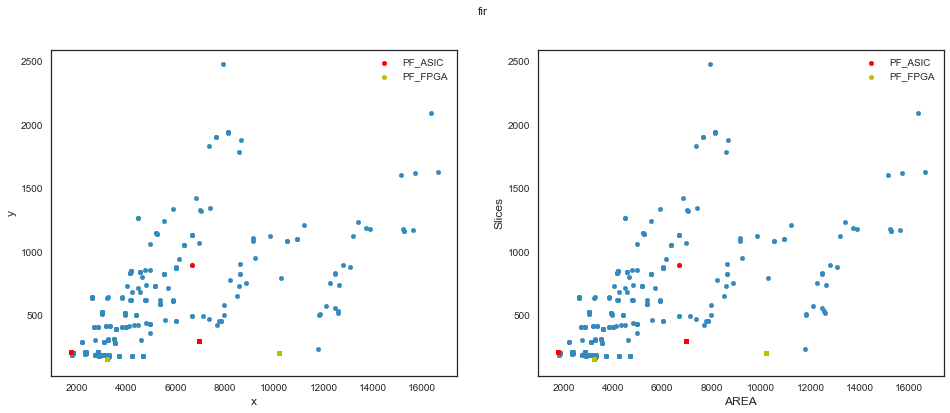

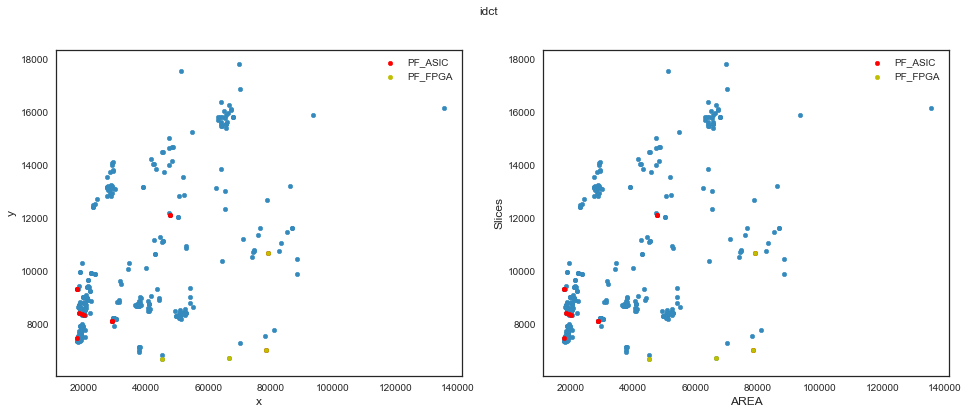

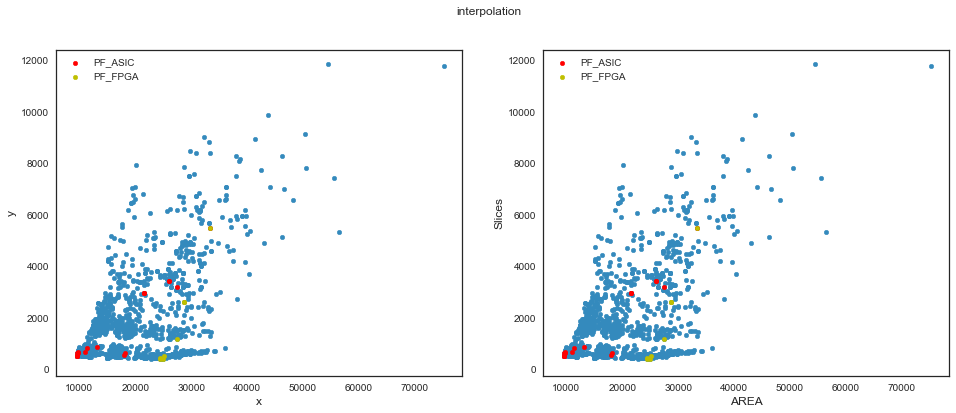

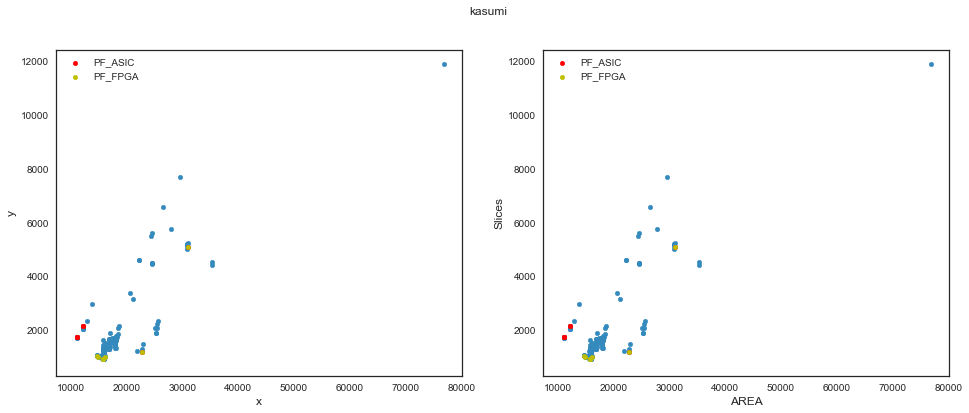

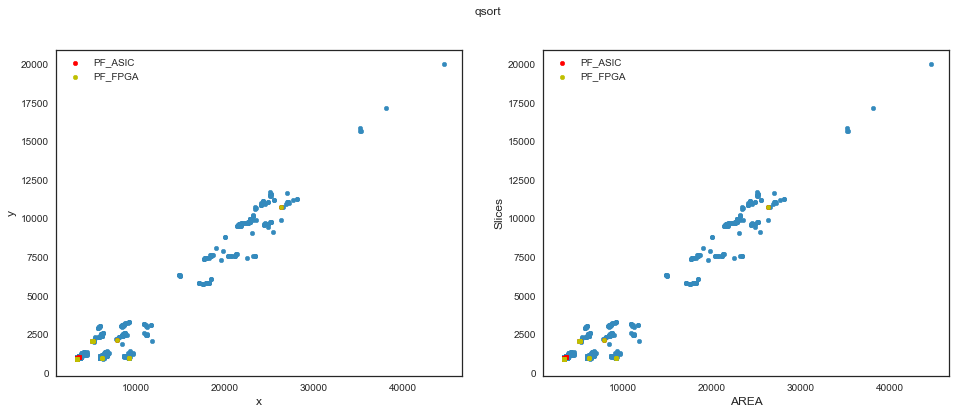

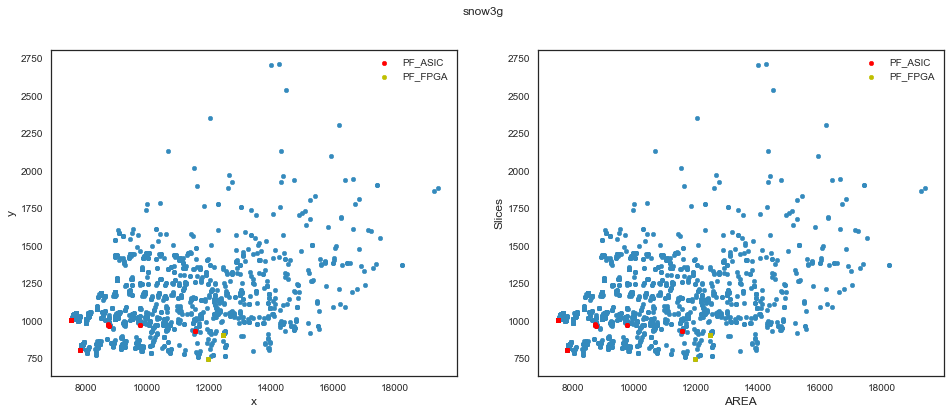

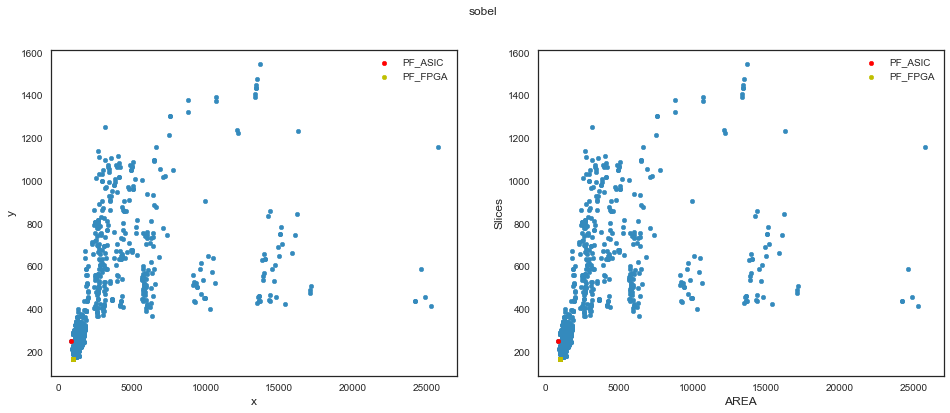

In [14]:
for benchmark in benchmarks:
    pca_plot(gd.data_v4[benchmark], title=benchmark, predictors=['AREA', 'Slices'])

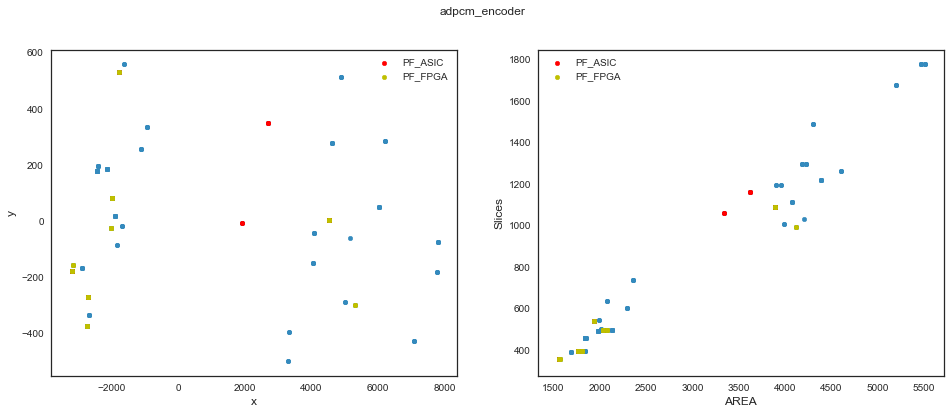

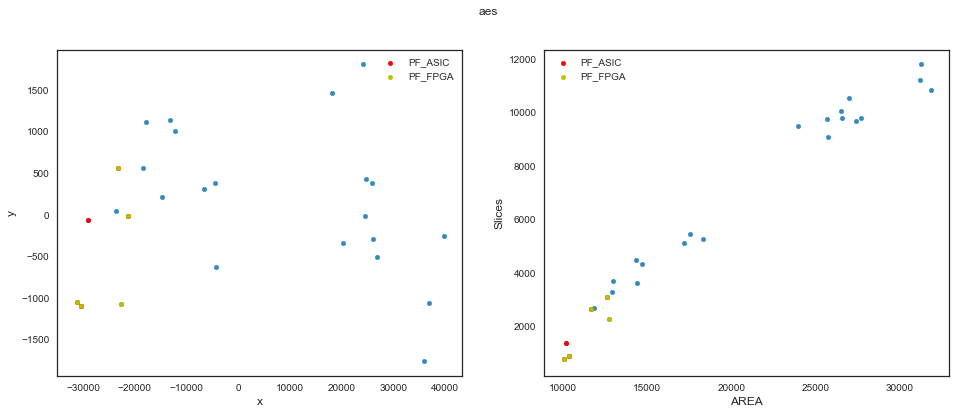

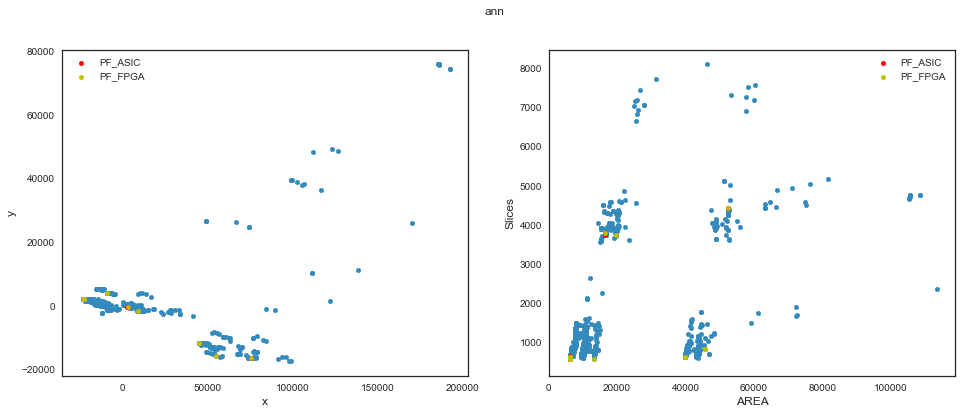

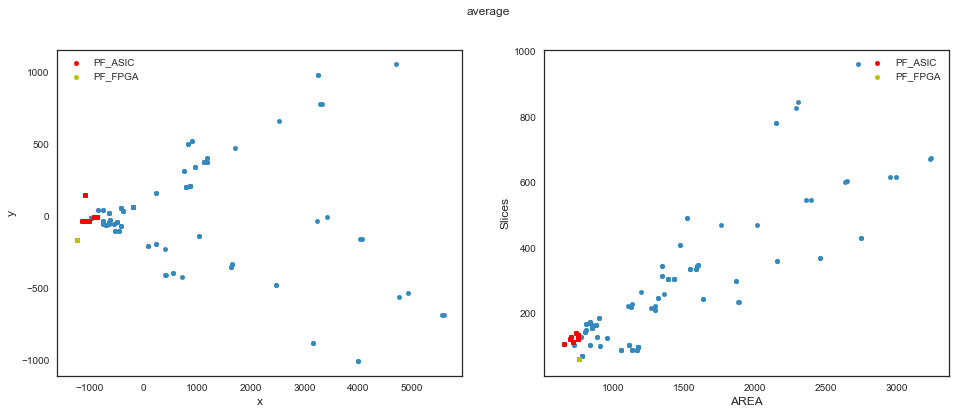

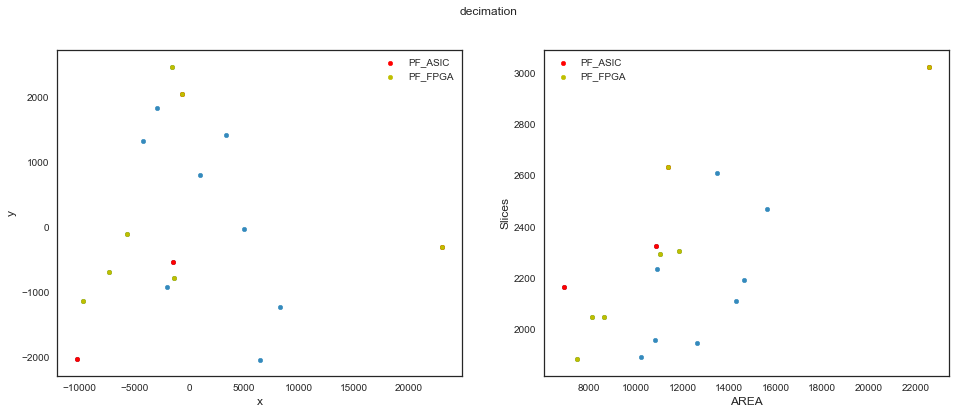

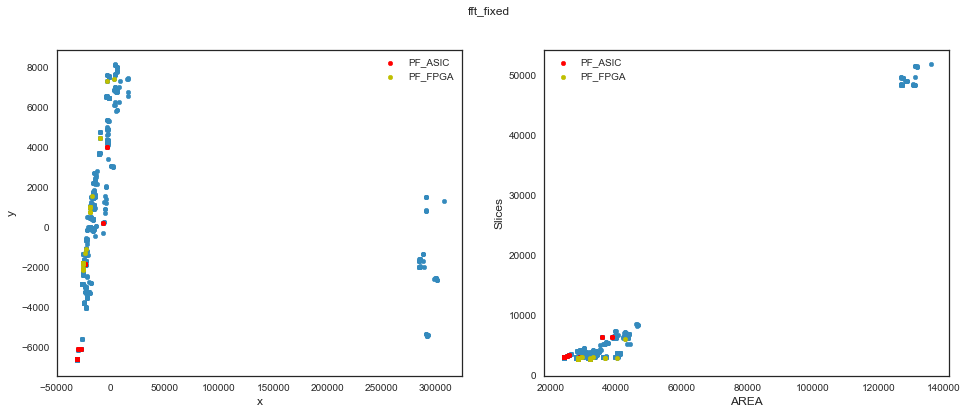

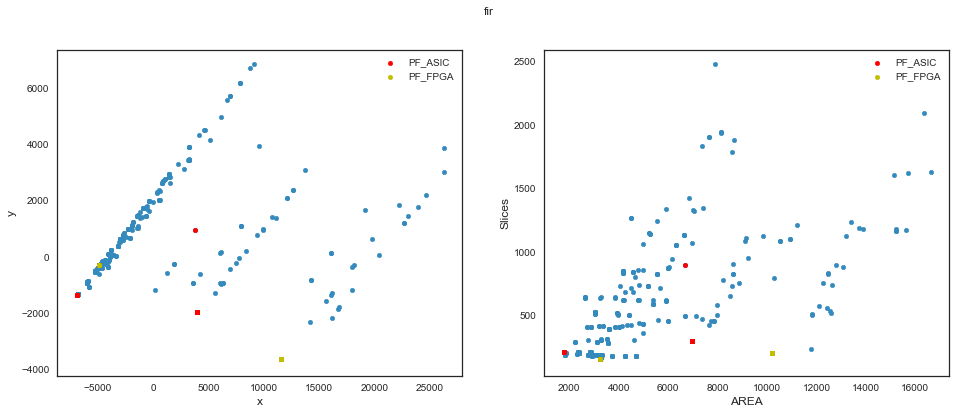

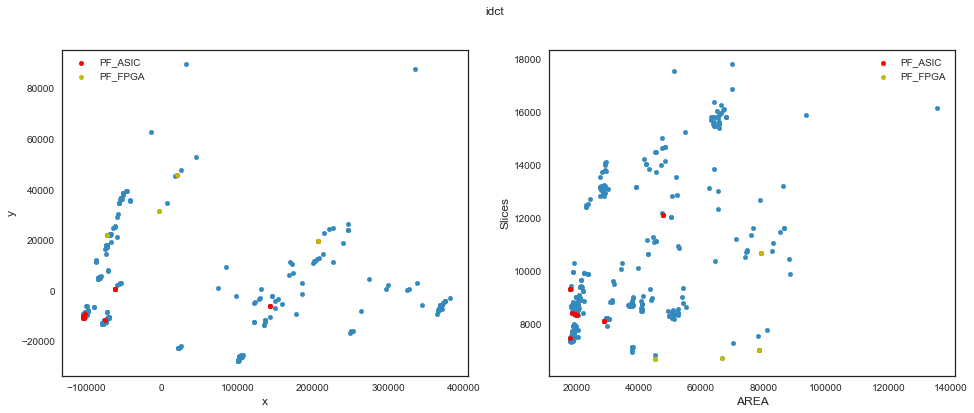

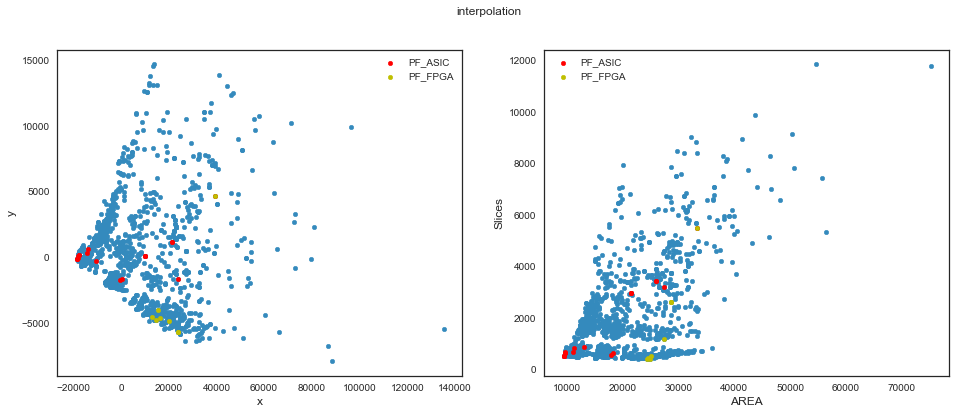

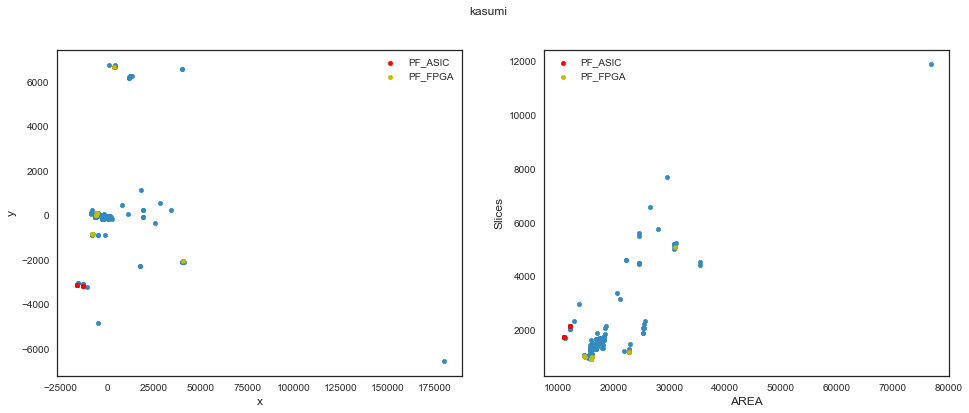

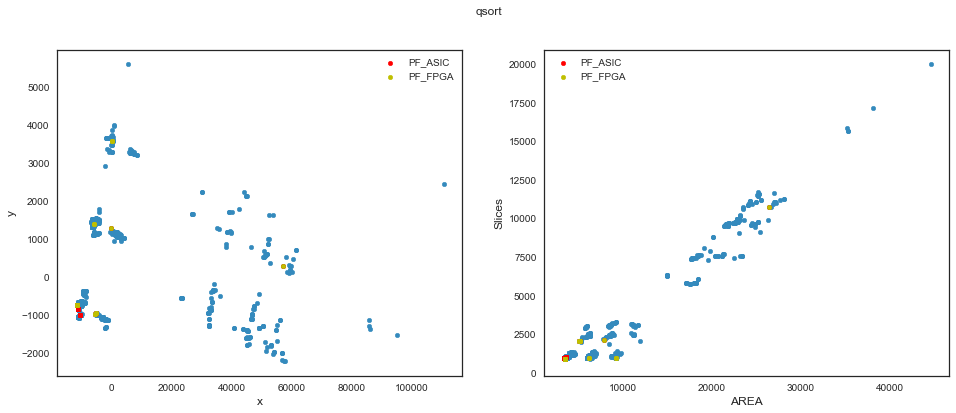

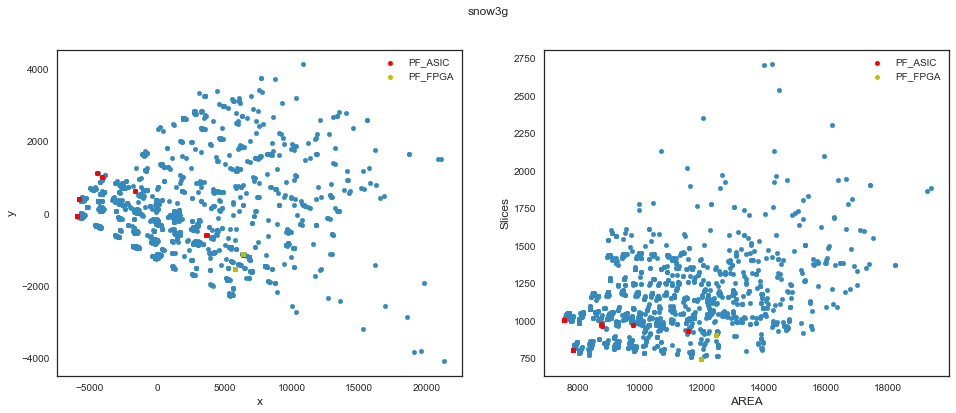

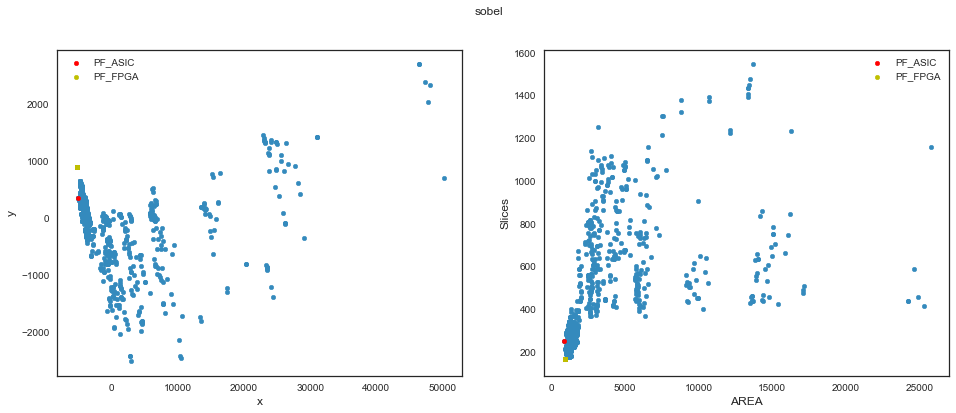

In [65]:
# select features and fix missing values
for benchmark in benchmarks:
    df = ML.fix_missing_data(gd.data_v4[benchmark])
    pca_plot(df, title=benchmark, predictors=valid_features)

In [15]:
es = es_v4_lr.copy()

In [50]:
lin_bench = ['adpcm_encoder', 'aes', 'average', 'fft_fixed', 'qsort']
lin_set = es.loc[es.test.isin(lin_bench)].reset_index(drop=True)
lin_set.sample(5)

,train,test,adrs_ave,adrs_max,adrs_ave_rms,adrs_max_rms,hypervolume,dominance,cardinality
275,fft_fixed;interpolation,qsort,0.0423,0.1667,0.0128,0.0483,0.7848,0.4286,11.0
10315,aes;ann;idct;interpolation;kasumi;snow3g,average,0.0000,0.0000,0.0000,0.0000,0.3539,1.0000,3.0
16017,ann;decimation;fir;interpolation;kasumi;qsort;...,adpcm_encoder,0.1763,0.5056,0.1762,0.5050,0.3163,0.3333,9.0
6148,aes;fir;idct;kasumi;sobel,average,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0
2501,aes;fft_fixed;fir;kasumi,qsort,0.0009,0.0063,0.0010,0.0071,0.9669,0.8571,10.0


In [51]:
def belong_to(sub_set, root_set):
    """Check if every element in `sub_set` is in `root_set`."""
    all_in = False
    for i in sub_set:
        if i in root_set:
            all_in = True
        else:
            all_in = False
            break
    return all_in

In [52]:
lin_set['belong_to'] = lin_set.train.apply(lambda x: belong_to(x.split(';'), lin_bench))

In [53]:
# training and testing sets are from `lin_bench`
lin_set_valid = lin_set.loc[lin_set.belong_to].reset_index(drop=True)

In [54]:
lin_set_valid.drop(['belong_to'], axis=1, inplace=True)

In [57]:
lin_set_valid.sample(10)

,train,test,adrs_ave,adrs_max,adrs_ave_rms,adrs_max_rms,hypervolume,dominance,cardinality
38,aes;qsort,adpcm_encoder,0.0903,0.2809,0.0902,0.2804,0.2720,0.5000,8.0
46,average;qsort,fft_fixed,0.0790,0.1911,0.0366,0.0997,0.8278,0.1667,10.0
44,average;qsort,adpcm_encoder,0.0024,0.0141,0.0024,0.0141,0.3882,0.8333,10.0
5,aes,average,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0
22,adpcm_encoder;aes,qsort,0.0146,0.0730,0.0147,0.0731,0.9378,0.5714,6.0
48,fft_fixed;qsort,aes,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,5.0
33,aes;average,fft_fixed,0.0296,0.0656,0.0258,0.0657,0.9460,0.3333,6.0
8,average,adpcm_encoder,0.0835,0.3333,0.0981,0.2687,0.3680,0.3333,5.0
69,average;fft_fixed;qsort,aes,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,5.0
70,adpcm_encoder;aes;average;fft_fixed,qsort,0.0222,0.0730,0.0223,0.0731,0.8314,0.4286,8.0


In [58]:
dm_lin = dm_v4.loc[dm_v4.benchmark.isin(lin_bench)]
dm_lin

,benchmark,adrs_ave,adrs_max,adrs_ave_rms,adrs_max_rms,hypervolume,dominance,cardinality
0,adpcm_encoder,0.0251,0.0978,0.0261,0.0875,0.2722,0.6667,6.0
1,aes,0.0043,0.0216,0.0319,0.1593,0.9669,0.8000,6.0
3,average,0.0000,0.0000,0.0000,0.0000,0.4526,1.0000,8.0
5,fft_fixed,0.0583,0.1154,0.0383,0.0856,0.7895,0.0000,8.0
10,qsort,0.0306,0.1667,0.0026,0.0110,0.9441,0.7143,7.0


In [59]:
combos, benches = es_vs_dm(lin_set_valid, dm_lin)

In [60]:
for i, j in zip(combos, benches):
    print(i)
    print(j)
    print()

average;fft_fixed;qsort
['adpcm_encoder', 'aes']

adpcm_encoder;fft_fixed;qsort
['aes', 'average']

adpcm_encoder;aes;fft_fixed;qsort
['average']

fft_fixed;qsort
['adpcm_encoder', 'aes', 'average']



In [67]:
gd.data_v4['average'].head(1)

,index,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,LOOP_1,LOOP_2,FUNC_1,Attr,Attr_with_L,Slices
0,0,1168,4,273,654,210,14,1953,890,4,4,4.0,17,0,2.048ns,-,-,-,-,16,-,-,-100,Cyber,array=REG,unroll_times=0,unroll_times=0,func=inline,ATTR=Cyber;ARRAY_1=array=REG;LOOP_1=unroll_tim...,ATTR=Cyber;ARRAY_1=array=REG;LOOP_1=unroll_tim...,87


In [68]:
gd.data_v4['fft_fixed'].head(1)

,index,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,ARRAY_2,LOOP_1,LOOP_2,LOOP_3,LOOP_4,LOOP_5,LOOP_6,LOOP_7,Attr,Attr_with_L,Slices
0,0,33561,12,24999,5172,3118,22,56207,25238,20,20,20.0,250,-,10.2052ns,-,-,-,-,19,-,-,0,Cyber,array=RAM,array=REG,unroll_times=all,unroll_times=all,unroll_times=all,folding=1,unroll_times=all,folding=1,folding=1,ATTR=Cyber;ARRAY_1=array=RAM;ARRAY_2=array=REG...,ATTR=Cyber;ARRAY_1=array=RAM;ARRAY_2=array=REG...,3412


In [69]:
gd.data_v4['qsort'].head(1)

,index,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,ARRAY_2,ARRAY_3,LOOP_1,LOOP_2,LOOP_3,LOOP_4,LOOP_5,LOOP_6,FUNC_1,Attr,Attr_with_L,Slices
0,0,8720,24,909,3576,4025,16,18602,6970,24,24,24.0,194,-,2.915ns,-,-,-,-,33,-,-,-100,Cyber,array=EXPAND+array_index=const,array=REG,array=RAM,folding=1,unroll_times=all,unroll_times=all,folding=0,unroll_times=all,folding=1,func=inline,ATTR=Cyber;ARRAY_1=array=EXPAND+array_index=co...,ATTR=Cyber;ARRAY_1=array=EXPAND+array_index=co...,2432


In [70]:
gd.data_v4['adpcm_encoder'].head(1)

,index,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,LOOP_1,FUNC_1,FUNC_2,Attr,Attr_with_L,Slices
0,0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,-,1.4275ns,-,-,-,-,21,-,-,100,Cyber,array=RAM,folding=1,func=goto,func=inline,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,394


In [71]:
gd.data_v4['aes'].head(1)

,index,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,...,LOOP_12,LOOP_13,LOOP_14,LOOP_15,LOOP_16,LOOP_17,LOOP_18,LOOP_19,LOOP_20,LOOP_21,LOOP_22,LOOP_23,FUNC_1,FUNC_2,FUNC_3,FUNC_4,FUNC_5,FUNC_6,FUNC_7,FUNC_8,FUNC_9,FUNC_10,Attr,Attr_with_L,Slices
0,0,26968,46,94,5490,20055,40,67412,23295,60,60,60.0,1289,-,1.4246ns,-,-,-,-,1442,-,-,100,Cyber,array=RAM,...,unroll_times=all,unroll_times=all,unroll_times=all,folding=1,unroll_times=all,folding=1,folding=1,unroll_times=0,folding=0,folding=1,folding=0,unroll_times=all,func=inline,func=inline,func=inline,func=goto,func=goto,func=goto,func=goto,func=inline,func=goto,func=inline,ATTR=Cyber;ARRAY_1=array=RAM;ARRAY_2=array=RAM...,ATTR=Cyber;ARRAY_1=array=RAM;ARRAY_2=array=RAM...,10538


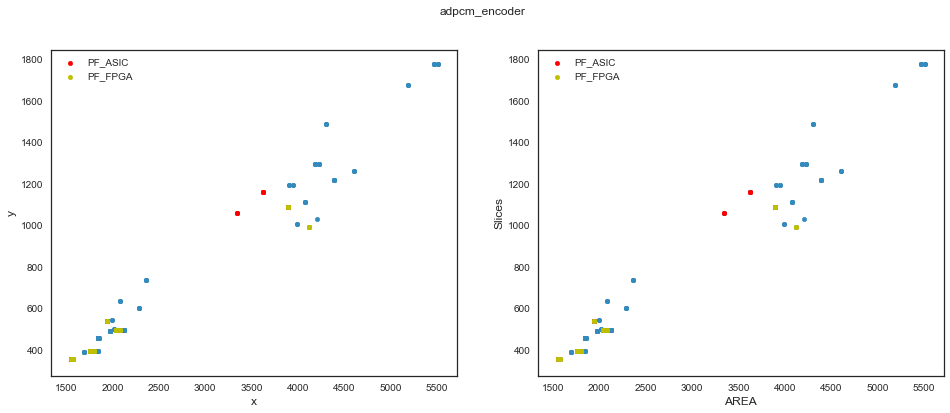

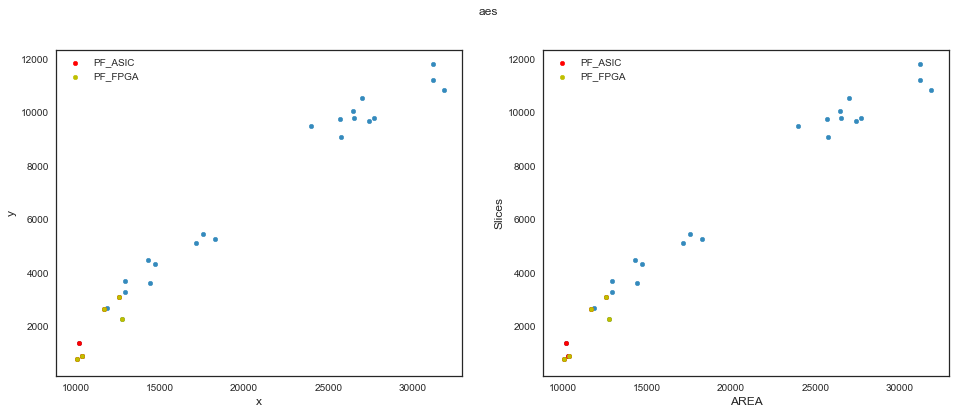

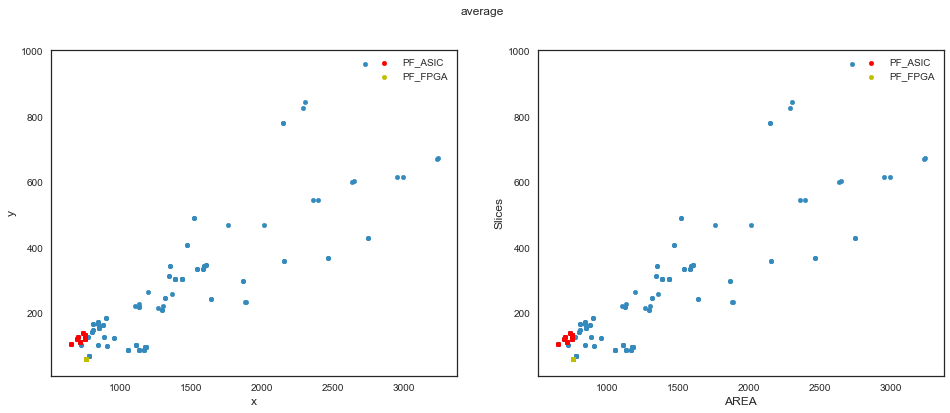

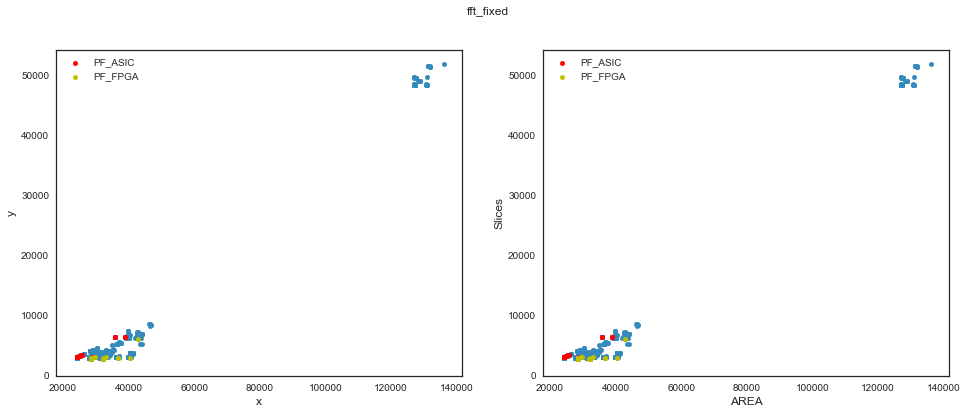

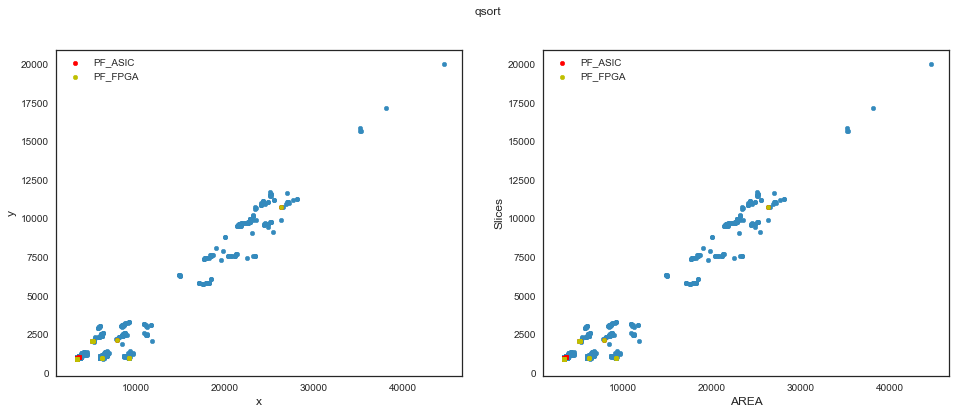

In [61]:
for benchmark in lin_bench:
    pca_plot(gd.data_v4[benchmark], title=benchmark, predictors=['AREA', 'Slices'])